# Clasificación Inteligente de Flores con Deep Learning
### Implementación de Transfer Learning usando Redes Neuronales Convolucionales - Juan Daniel Garcia Ruiz

## Configuración Inicial y Librerías Esenciales

In [18]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use("Agg") 
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


## Configuración de Hiperparámetros del Modelo

In [19]:
# ==============================================
# CONFIG
# ==============================================
AUTO = tf.data.AUTOTUNE

IMAGE_SIZE = (224, 224)         # recomendado para GPU
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 104

DATA_PATH = "data/tfrecords-jpeg-224x224"

print("=== Entrenando Transfer Learning (VGG16) ===")
print("Leyendo TFRecords...")

=== Entrenando Transfer Learning (VGG16) ===
Leyendo TFRecords...


## Procesamiento y Decodificación de Datos
Convierte los bytes de la imagen a un tensor RGB, lo redimensiona al tamaño requerido por el modelo y normaliza los valores a [0,1].
También extrae la etiqueta (class) y la convierte al tipo adecuado.

In [20]:
# ==============================================
# TFRECORD PARSING
# ==============================================
def decode_example(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, features)

    # 1. Decode JPEG
    image = tf.image.decode_jpeg(example["image"], channels=3)

    # 2. Convertir a float32 (IMPORTANTÍSIMO)
    image = tf.image.convert_image_dtype(image, tf.float32)  # → [0,1]

    # 3. Redimensionar
    image = tf.image.resize(image, IMAGE_SIZE)

    # 4. Guardar versión RAW para mostrar
    image_raw = image

    # 5. Preprocesar como VGG16 espera (BGR, mean-subtraction)
    #    OJO: preprocess_input espera float32 en rango 0–255 (NO 0–1)
    image_pp = image * 255.0
    image_pp = tf.keras.applications.vgg16.preprocess_input(image_pp)

    label = tf.cast(example["class"], tf.int32)

    return image_pp, label, image_raw

## Carga Eficiente de Dataset en Formato TFRecords
- Esta función localiza todos los archivos .tfrec dentro de la carpeta indicada y los carga como un TFRecordDataset.
- Luego aplica la función de parsing (decode_example) para convertir cada registro en (imagen, etiqueta).

In [21]:
def load_tfrecords(folder):
    files = tf.io.gfile.glob(f"{folder}/*.tfrec")
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    dataset = dataset.map(decode_example, num_parallel_calls=AUTO)
    return dataset

## Crear los datasets de entrenamiento y validación
train_ds = load_tfrecords(f"{DATA_PATH}/train")
train_ds_model = train_ds.map(
    lambda img_pp, label, img_raw: (img_pp, label)
).shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO)


val_ds = load_tfrecords(f"{DATA_PATH}/val")
val_ds_model = val_ds.map(
    lambda img_pp, label, img_raw: (img_pp, label)
).batch(BATCH_SIZE).prefetch(AUTO)


train_ds_vis = train_ds.map(
    lambda img_pp, label, img_raw: (img_raw, label)
).batch(BATCH_SIZE)





In [22]:
for imgs, labels in train_ds_model.take(1):
    print(labels.numpy())


[ 53  68  79  39  90  13 103  67  24  67  67  71  24   4  14 103  73  64
  49  46  45  71  75  73  67  67  13  48  78  33   4  97]


## Taxonomía de Especies: 104 Clases de Flores

In [23]:
# ==============================================
# DISPLAY UTILS - Kaggle Style
# ==============================================
CLASSES = [
    "pink primrose","hard-leaved pocket orchid","canterbury bells","sweet pea","wild geranium","tiger lily",
    "moon orchid","bird of paradise","monkshood","globe thistle","snapdragon","colt's foot","king protea",
    "spear thistle","yellow iris","globe-flower","purple coneflower","peruvian lily","balloon flower",
    "giant white arum lily","fire lily","pincushion flower","fritillary","red ginger","grape hyacinth",
    "corn poppy","prince of wales feathers","stemless gentian","artichoke","sweet william","carnation",
    "garden phlox","love in the mist","cosmos","alpine sea holly","ruby-lipped cattleya","cape flower",
    "great masterwort","siam tulip","lenten rose","barberton daisy","daffodil","sword lily","poinsettia",
    "bolero deep blue","wallflower","marigold","buttercup","daisy","common dandelion","petunia","wild pansy",
    "primula","sunflower","lilac hibiscus","bishop of llandaff","gaura","geranium","orange dahlia",
    "pink-yellow dahlia","cautleya spicata","japanese anemone","black-eyed susan","silverbush",
    "californian poppy","osteospermum","spring crocus","iris","windflower","tree poppy","gazania","azalea",
    "water lily","rose","thorn apple","morning glory","passion flower","lotus","toad lily","anthurium",
    "frangipani","clematis","hibiscus","columbine","desert-rose","tree mallow","magnolia","cyclamen",
    "watercress","canna lily","hippeastrum","bee balm","pink quill","foxglove","bougainvillea","camellia",
    "mallow","mexican petunia","bromelia","blanket flower","trumpet creeper","blackberry lily","common tulip",
    "wild rose"
]


## Funciones Auxiliares para Procesamiento
- Herramientas de utilidad para facilitar el procesamiento y visualización de datos

In [24]:
def batch_to_numpy(batch):
    imgs, lbls = batch
    return imgs.numpy(), lbls.numpy()

def title_from_pred(pred, real):
    ok = (pred == real)
    t = f"{CLASSES[pred]} | {'OK' if ok else 'NO → ' + CLASSES[real]}"
    return t, ok

def display_batch(batch, preds=None):
    imgs, lbls = batch_to_numpy(batch)

    rows = int(math.sqrt(len(imgs)))
    cols = len(imgs)//rows

    plt.figure(figsize=(13, 13))
    index = 1
    for i in range(rows*cols):
        plt.subplot(rows, cols, index)
        plt.axis("off")
        plt.imshow(imgs[i])
        if preds is not None:
            t, ok = title_from_pred(preds[i], lbls[i])
            plt.title(t, color="red" if not ok else "black")
        else:
            plt.title(CLASSES[lbls[i]])
        index += 1

    plt.tight_layout()
    plt.savefig("debug_batch.png")   # ⭐⭐ archivo
    print("Guardado: debug_batch.png")
    plt.show()


def display_curve(train, val, title, subplot):
    if subplot % 10 == 1:
        plt.figure(figsize=(10,10))
    ax = plt.subplot(subplot)
    ax.plot(train)
    ax.plot(val)
    ax.set_title(title)
    ax.legend(["train","val"])



## Visualización de Lotes de Imágenes de Entrenamiento

In [25]:
for img_pp, label, img_raw in train_ds.take(1):
    print("Label real (del tfrecord):", label.numpy())
    break


Label real (del tfrecord): 57


In [26]:
for batch in train_ds_vis.take(1):
    display_batch(batch)

Guardado: debug_batch.png


## Arquitectura del Modelo: VGG16 con Transfer Learning

In [27]:
# ==============================================
# TRANSFER LEARNING: VGG16
# ==============================================
print("Construyendo modelo VGG16...")

base = keras.applications.VGG16(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

base.trainable = False

inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Construyendo modelo VGG16...


## Proceso de Entrenamiento con Optimización Adaptativa
- Entrenamos el modelo utilizando los lotes de entrenamiento y validación.

- Se usa `EarlyStopping` para detener el entrenamiento cuando la precisión de validación deja de mejorar, evitando sobreajuste y restaurando los mejores pesos alcanzados.
- La métrica principal monitoreada es val_accuracy y se entrena durante un máximo de EPOCHS

In [46]:
# ==============================================
# TRAINING
# ==============================================
print("🚀 Entrenando modelo...")

history = model.fit(
    train_ds_model,
    validation_data=val_ds_model,
    epochs=EPOCHS
)

print("=== ENTRENAMIENTO COMPLETADO ===")

🚀 Entrenando modelo...
Epoch 1/20
399/399 [==============================] - 584s 1s/step - loss: 3.6969 - accuracy: 0.3859 - val_loss: 1.7369 - val_accuracy: 0.5905
Epoch 2/20
399/399 [==============================] - 578s 1s/step - loss: 1.1551 - accuracy: 0.7084 - val_loss: 1.3133 - val_accuracy: 0.6856
Epoch 3/20
399/399 [==============================] - 584s 1s/step - loss: 0.7536 - accuracy: 0.8011 - val_loss: 1.1138 - val_accuracy: 0.7368
Epoch 4/20
399/399 [==============================] - 588s 1s/step - loss: 0.5565 - accuracy: 0.8484 - val_loss: 1.0698 - val_accuracy: 0.7416
Epoch 5/20
399/399 [==============================] - 578s 1s/step - loss: 0.4438 - accuracy: 0.8777 - val_loss: 1.0472 - val_accuracy: 0.7559
Epoch 6/20
399/399 [==============================] - 580s 1s/step - loss: 0.3582 - accuracy: 0.9021 - val_loss: 1.0415 - val_accuracy: 0.7643
Epoch 7/20
399/399 [==============================] - 583s 1s/step - loss: 0.3056 - accuracy: 0.9169 - val_loss: 1.0490

In [ ]:
for img_pp, label, img_raw in train_ds.take(1):
    pred = model.predict(img_pp[None, ...])
    print("label real:", label.numpy())
    print("pred:", np.argmax(pred))
    break


In [57]:
for imgs_pp, labels in train_ds_model.take(1):
    preds = model.predict(imgs_pp)
    print("real:", labels.numpy())
    print("pred:", np.argmax(preds, axis=1))


1/1 [==============================] - 1s 1s/step
real: [ 69  95  83   0  73   3  49  16 103   4   8  75  73  80  71 103  10  86
  47  14 103  23  13   4  87  13  49  74  14  57  28   5]
pred: [ 69  95  83   0  73   3  49  16 103   4   8  75  73  80  71 103  10  86
  47  14 103  23  13   4  87  13  49  74  14  57  28   5]


In [58]:
for img_pp, label, img_raw in train_ds.take(1):
    pred = model.predict(img_pp[None,...])
    print("real:", label.numpy(), "pred:", pred.argmax())


1/1 [==============================] - 0s 75ms/step
real: 57 pred: 57


In [59]:
for img_pp, label in train_ds_model.take(1):
    pred = model.predict(img_pp)
    print("real:", label.numpy())
    print("pred:", np.argmax(pred, axis=1))


1/1 [==============================] - 1s 1s/step
real: [ 67  39  75  49  46  52 103  22  73   0  48  50  46  49 103  62  43 103
  86  53  13  68  73  68  46   4   0  94  47  69   4  76]
pred: [ 67  39  75  49  46  52 103  22  73   0  48  50  46  49 103  62  43 103
  86  53  13   4  73  68  46   4   0  94  47  69   4  76]


In [60]:
import tensorflow as tf

DATA_PATH = "data/tfrecords-jpeg-224x224"

ds = tf.data.TFRecordDataset(tf.io.gfile.glob(f"{DATA_PATH}/train/*.tfrec"))
def parse(example):
    features = {"class": tf.io.FixedLenFeature([], tf.int64)}
    ex = tf.io.parse_single_example(example, features)
    return ex["class"]

labels = set()

for x in ds.map(parse).take(10000):
    labels.add(int(x.numpy()))

print(sorted(labels))
print("Cantidad:", len(labels))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
Cantidad: 104


In [61]:
labels = set()
for img_pp, label in train_ds_model.unbatch().take(50000):
    labels.add(int(label.numpy()))
print(sorted(labels))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]


## Análisis de Curvas de Aprendizaje y Convergencia

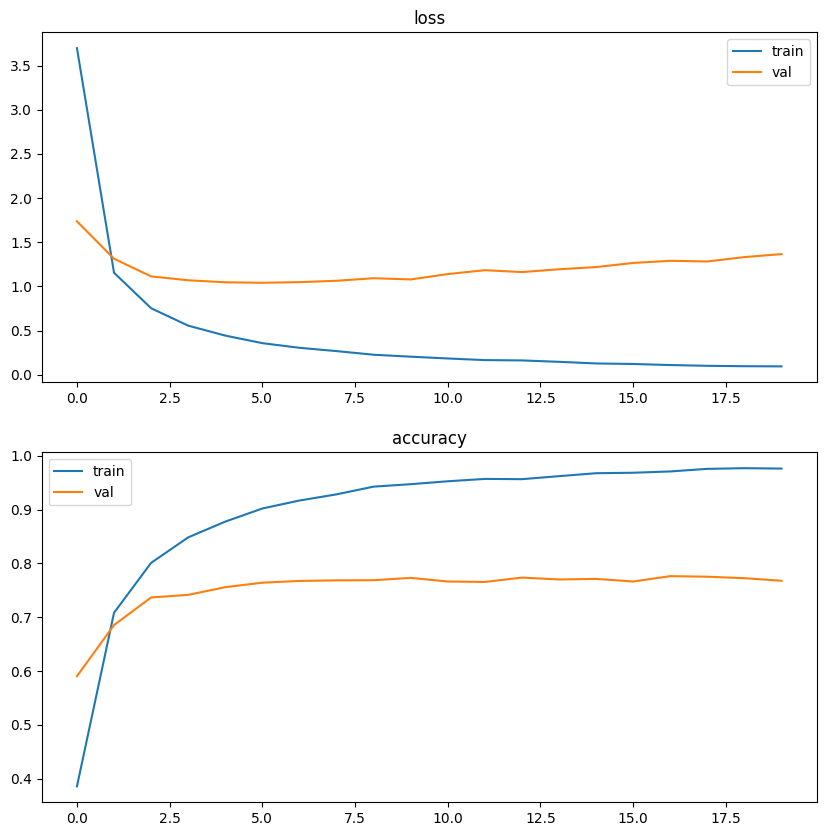

In [62]:
# ==============================================
# TRAINING CURVES
# ==============================================
display_curve(history.history["loss"], history.history["val_loss"], "loss", 211)
display_curve(history.history["accuracy"], history.history["val_accuracy"], "accuracy", 212)
plt.show()

## Despliegue Web: Conversión a TensorFlow.js

In [64]:
# ==============================================
# OPCIONAL: Exportar a TFJS
# ==============================================
EXPORT_TFJS = True

if EXPORT_TFJS:
    print("💾 Exportando modelo a TensorFlow.js...")
    import tensorflowjs as tfjs
    os.makedirs("web_model_flowers", exist_ok=True)
    tfjs.converters.save_keras_model(model, "web_model_flowers")
    print("✅ Exportación completada: carpeta web_model_flowers/")


💾 Exportando modelo a TensorFlow.js...
✅ Exportación completada: carpeta web_model_flowers/
